In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [2]:
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.ml.feature import OneHotEncoder, StringIndexer, Binarizer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import PCA
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [3]:
from jyquickhelper import add_notebook_menu
from progressbar import ProgressBar

In [4]:
add_notebook_menu()

# Preprocessing

The purpose of this notebook is to process the variables of interest to make them suitable for a ml pipeline. Next, we summarize the transformations we intend to apply to the variables in `df`.

|Var Name | type| Processing |
|:--|:--|:--|
|'grav' | integer | ** |
| 'Num_Acc'|long | | 
| 'num_veh'|string | drop |
| 'mois'|integer |OneHotEncoder (\*) |
| 'an'|integer | (x-5)|
| 'hrmn'|integer | drop |
| 'lum' |integer |OneHotEncoder (\*)|
| 'dep' |integer |drop |
| 'com' |integer |drop |
| 'agg' |integer |(x-1) |
| 'int' |integer |OneHotEncoder (\*)|
| 'atm' |integer |OneHotEncoder (\*)|
| 'col' |integer |OneHotEncoder (\*)|
| 'catr'|integer |OneHotEncoder (\*)|
| 'circ'|integer |OneHotEncoder (\*)|
| 'nbv' |integer | |
| 'prof'|integer |OneHotEncoder (\*)|
| 'plan'|integer |OneHotEncoder (\*)|
| 'larrout'|integer | |
| 'surf'|integer | OneHotEncoder (\*)|
| 'infra'|integer | OneHotEncoder (\*)|
| 'situ'|integer | OneHotEncoder (\*)|
| 'catv'|integer | OneHotEncoder (\*) + reduce #typo|
| 'obs' |integer |OneHotEncoder (\*)|
| 'obsm'|integer |OneHotEncoder (\*)|
| 'choc'|integer |OneHotEncoder (\*)|
| 'manv'|integer |OneHotEncoder (\*)|
| 'place'|integer | drop |
| 'catu'|integer | OneHotEncoder (\*)|
| 'sexe'|integer | OneHotEncoder (\*)|
| 'An_nais'|integer | (x-45)^2 |
| 'secu'|integer | ? |

In [5]:
df = spark.read.csv("dataSample/df_keep.csv", 
                    inferSchema=True, 
                    header=True)

In [6]:
df = df.sample(withReplacement=False, fraction=.2)

## Drop na

Prior to any data processing and model estimation we need to drop all rows with `null` values

In [7]:
df = df.na.drop()

## Target

**Reminder**: `grav` is coded as follows:

- 1: None
- 2: death
- 3: hospital
- 4: minor

We chose to transform this typology into a binary variable (called `grav_bin`) where :

- `grav_bin` = 0 if `grav`==None
- `grav_bin` = 1 else

Our prediction task is thus a classification task

In [8]:
def make_ord(x):
    if x==1:
        return(0) # None : 0
    else:
        return(1) # else : 1
udf_ord = udf(make_ord, IntegerType())    

In [9]:
df = df.withColumn("grav_bin", udf_ord("grav"))

**Check**: we check that our binary variable is balanced, which is the case.

In [10]:
df.groupBy("grav_bin").count().show()

+--------+------+
|grav_bin| count|
+--------+------+
|       1|371904|
|       0|307504|
+--------+------+



In [11]:
df = df.persist()

## Features

### Catv

Due to the very large number of categories (including outdated categories) we chose to restrict to 5 categories (as in Section 2), aka : 

- 1: bike
- 2: motorbike
- 3: car
- 4: bus
- 99: other

In [12]:
def vehicle_conversion(x):
    if (x in {2, 4, 5, 6,30 , 31, 32, 33, 34}):
        return(int(2)) # motorbike
    if (x in {3, 7, 10}):
        return(int(3)) # car
    if (x in {37, 18}):
        return(int(4)) # bus
    if (x in {1}):
        return(int(1)) # bike
    else:
        return(int(99))

udf_vehicle_conversion = udf(vehicle_conversion, StringType())

In [13]:
df = df.withColumn("catv_str",udf_vehicle_conversion("catv"))
df = df.withColumn("catv_int", df["catv_str"].cast("int"))
df = df.drop("catv","catv_str")
df = df.withColumnRenamed("catv_int", "catv")

In [14]:
df.groupBy("catv").count().sort("catv",ascending=True).show()

+----+------+
|catv| count|
+----+------+
|   1| 22111|
|   2|133326|
|   3|486898|
|   4|  5772|
|  99| 31301|
+----+------+



### Numeric transfo

Did not find how to do it directly in the pipeline. Is it even possible ? 

In [15]:
df = df.withColumn("an_mod", df.an - 5)
df = df.withColumn("An_nais_mod", pow(df.An_nais - 45, 2))

In [16]:
def get_dummy(x):
    if x==1:
        return(0)
    else:
        return(1)
udf_dum = udf(get_dummy, IntegerType())    

In [17]:
df = df.withColumn("agg_mod", udf_dum("agg"))

In [18]:
df = df.persist()

# Prediction task

## Train-test

In [19]:
df_train, df_test =  df.randomSplit([.7, .3])

## Pipeline stages

### OneHotEncoder

We need to transform categorical variables to make them understandable by spark `ml` models. 

**Beware**: Depending on the model, we need to drop a category to avoid colinearity (eg, linear regression) or not (eg, CART).

In [20]:
encode_col = ["mois", "lum", "int", "atm", "col", "catr", 
              "circ", "prof", "plan", "surf", "infra", "situ", "catv",
              "obs", "obsm", "choc", "manv", "catu", "sexe"]
encoder_dl= [] # droplast=True
encoder_ndl= [] # droplast=False

for col in encode_col:
    encoder_dl += [OneHotEncoder(inputCol=col,
                                      outputCol=col+"_Vec")]
    encoder_ndl += [OneHotEncoder(inputCol=col,
                                       outputCol=col+"_Vec",
                                       dropLast=False)]

### VectorAssembler

In [21]:
cat_col = [col + "_Vec" for col in encode_col]
mod_col = ["an_mod", "An_nais_mod", "agg_mod"]
task_col = cat_col + mod_col


In [22]:
assembler = [VectorAssembler(inputCols=task_col, 
                                     outputCol='features')]

### PCA

Dimensionality reduction might be useful due to large number of categories and thus variables. In theory, similar task might be achieved through regularization but in practice this might not be sufficient. 

In [23]:
pca = [PCA(k=10, inputCol='features', outputCol='featuresPCA')]

### Models

In [25]:
lr = LinearRegression(labelCol="grav_bin", featuresCol='featuresPCA')

In [37]:
lo = LogisticRegression(labelCol="grav_bin", featuresCol='featuresPCA', maxIter=10,)

## Models estimation

### Linear Regression

In [46]:
binz = [Binarizer(threshold=.5, 
                      inputCol="prediction", outputCol="pred_bin")]

In [47]:
Stages = encoder_dl + assembler + pca + [lr] + binz
PipelineModel = Pipeline(stages=Stages)
df_trte_lr = PipelineModel.fit(df_train).transform(df_test)

In [48]:
lrModel = lr.fit(df_trte_lr.drop("prediction"))

In [49]:
lrModel.coefficients

DenseVector([0.0, 0.005, 0.0382, 0.0639, 0.0009, 0.0416, 0.0483, 0.0663, 0.0506, -0.0314])

### Logistic Regression

In [34]:
Stages = encoder_dl + assembler + pca + [lo]
PipelineModel = Pipeline(stages=Stages)

For the Logistic Regression, we decide to add a grid Search to optimize on several hyperparameters, namely :
- `RegParam` ($\lambda$ in the following formula)
- `ElasticNetParam` (combination of $L_1$ and $L_2$ regularizations; $\alpha$ in the following formula)
    $$\alpha \left( \lambda \|w\|_1 \right) + (1-\alpha) \left( \frac{\lambda}{2}\|w\|_2^2 \right) , \alpha \in [0, 1], \lambda \geq 0$$

In [38]:
# We now treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
paramGridSearch = (ParamGridBuilder()
                   .addGrid(lo.regParam, [0.01, 0.1, 1]) 
                   .addGrid(lo.elasticNetParam, [0.0, 0.5, 1.0])
                   .build())

eval_lo = BinaryClassificationEvaluator(labelCol="grav_bin")

crossval = CrossValidator(estimator=PipelineModel,
                    estimatorParamMaps=paramGridSearch,
                    evaluator=eval_lo,
                    numFolds=3)

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(df_train)

In [44]:
df_trte_lo = cvModel.transform(df_test)
loModel = lo.fit(df_trte_lo.drop("rawprediction","prediction","probability"))
loModel.coefficients

DenseVector([0.0, 0.0154, 0.1643, 0.2709, -0.0084, 0.1873, 0.2143, 0.311, 0.2389, -0.1486])

## Models evaluation

### Linear Regression

**Check**: we check that our predictor does predict both zeros and ones (it does).

In [50]:
df_trte_lr.groupBy("pred_bin").count().show()

+--------+------+
|pred_bin| count|
+--------+------+
|     0.0| 69485|
|     1.0|133713|
+--------+------+



Next we look at the confusion matrix and some basic statistics.

In [51]:
lr_conf_df = df_trte_lr.select("pred_bin", "grav_bin").toPandas()

In [52]:
def draw_confmat(true_l, pred_l):
    """Returns the confusion matrix and basic statistics
    :param true_l: (list) true labels
    :param pred_l: (list) predicted labels
    :return: confusion matrix and basic statistics
    """
    mat = confusion_matrix(true_l,
                pred_l)
    sns.heatmap(mat.T,
                square=True,
                annot=True,
                fmt='d',
                cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    print("{0:.2f}% of the test set is well classified".\
          format((mat[0,0]+mat[1,1])/len(lr_conf_df)*100))

58.99% of the test set is well classified


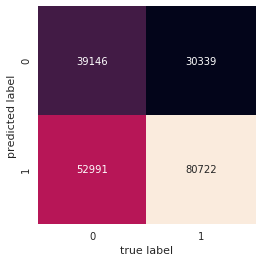

In [53]:
draw_confmat(lr_conf_df.grav_bin.values,
                lr_conf_df.pred_bin.values)


### Logistic Regression

In [57]:
df_trte_lo.groupBy("prediction").count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0| 69794|
|       1.0|133404|
+----------+------+



In [58]:
lo_conf_df = df_trte_lo.select("prediction", "grav_bin").toPandas()

58.98% of the test set is well classified


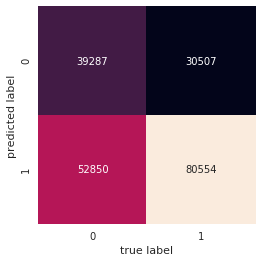

In [59]:
draw_confmat(lo_conf_df.grav_bin.values,
            lo_conf_df.prediction.values)

> The performance is actually fairly bad. However, due to computational issues (our local version of Spark needs quite a long time to perform the cross validation, we cannot test more hyperparameters.